<a href="https://colab.research.google.com/github/AndrewH707/MazeGrid/blob/main/Cogs182_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import collections

In [9]:
import numpy as np
from matplotlib import pyplot as plt

Actions = {
    0: [-1, 0], # north
    1: [1, 0], # south
    2: [0, -1], # west
    3: [0, 1] # east
} 

##################
# In this game, there are two fixed bombs and the agent randomly starts
# at one of the four corners. There are four barriers blocking the entrance
# to the desired terminal state(the chest). There are only two appropriate
# paths to the chest. The two bombs are also terminal states. 
####################

class MazeGrid():

  def __init__(self, size):
    # this function initializes the environment 
    self.size = size 
    self.hard_reset()
    return

  def hard_reset(self):
    self.state_action_values = collections.defaultdict(float)
    self.reset()

  def reset(self): # this function resets the grid to initial conditions
    self.terminal  = False
    self.current_state = self.corner()
    return
  
  # randomly picks corner to start new game from
  def corner(self):
    row, column = np.random.choice([0, 8], 2)
    corner = (row, column)
    return corner

  def collision(self, state):
    # this function checks whether the given state is a collision with 
    # a barrier
    # returns true for collision,  false for no collision
    if state in [(4, 3), (5, 3), (6, 3), (7, 3), (7, 4), (1, 4), (1, 5), (2, 5), (3, 5), (4, 5)]:
      return True
    else: return False

  def bomb(self, state):
    # checks to see if the given state is on a bomb and returns true if it is
    if state in [(3, 3), (5, 5)]:
      return True
    else:
      return False

  def step(self, current_state, action, change_values = True): # this step function takes in an action and 
                                 # the current state as input. 

    reward = -1 # on all non-terminal transitions 
    size = self.size - 1

    s_prime = (current_state[0] + action[0], current_state[1] + action[1])
   
   # check out of bounds condition vertical
    if s_prime[0] < 0 or s_prime[0] > size:
      s_prime = current_state # return same state
    # check out of bounds condition; horizontal
    if s_prime[1] < 0 or s_prime[1] > size:
      s_prime = current_state
    # check for any collisions with barriers 
    if (self.collision(s_prime) == True):
      s_prime = current_state
    
        # check for any bombs
    if (self.bomb(s_prime) == True):
      reward = -5
      if (change_values == True):
        self.terminal = True

    # check to see if end goal is met
    if (s_prime == (4, 4)):
      if (change_values == True):
        self.terminal = True

    #no more remaning checks, return next state and reward
    if (change_values == True):
      self.current_state = s_prime
    
    return s_prime, reward 

  def best_action(self, state):
    up = self.state_action_values[state, 0]
    down = self.state_action_values[state, 1]
    left = self.state_action_values[state, 2]
    right = self.state_action_values[state, 3]
    action_values  = [up, down, left, right]
    a = np.random.choice(np.flatnonzero(action_values == np.max(action_values)))
    return a # return index of the best Action

  def e_greedy(self, epsilon, state):
    greedy = (1 - epsilon) + (epsilon/len(Actions))
    non_greedy = epsilon/len(Actions)
    p = [greedy, non_greedy]
    p = np.array(p)
    p /= p.sum() #normalize probabilities so they sum to 1
    choice = np.random.choice(['greedy', 'non-greedy'], p = p)  

    if choice == 'greedy':
      action_index = self.best_action(state)# return index of best action

    else:

      index_options = [0, 1, 2, 3]
      index_options.remove(self.best_action(state))
      action_index = np.random.choice(a = index_options) # a random choice from a list 
                                                # of non-optimal action indicies
      
    return action_index


  def MC_episode(self, epsilon):
    self.reset()
    episode = []
    current_state = self.current_state
    terminal = self.terminal
    while (terminal != True):
      action_index = self.e_greedy(epsilon, current_state)
      action = Actions[action_index]
      next_state, reward = self.step(current_state, action)
      episode.append((current_state, action_index, reward))
      current_state = next_state
      terminal = self.terminal
    return episode

  # Here, we implmenent an on-policy first-visit algorithm for 
  # Monte Carlo control

  def on_policy_first_visit_MC(self, gamma = 1, epsilon = 0.1, episodes = 500):
    self.hard_reset()
    counts = collections.defaultdict(int)
    returns = collections.defaultdict(float)

    for i in range(episodes): # number of episodes
      episode = self.MC_episode(epsilon)
      G = 0 # initialize return
      state_action_pairs = [(s, a) for (s, a, r) in episode]
      visited = collections.defaultdict(lambda:False)
      for t, (state, action, reward) in enumerate(episode):
        # check if the pair already exists
        if (visited[state, action] != True):
          G = gamma*G + reward
          returns[state, action] += G
          counts[state, action] += 1
          self.state_action_values[state, action] = returns[state, action]/counts[state, action]
          visited[state, action] = True

      if ((i+1) % 10 == 0):
        print('Episode:', i+1)
        self.visualize(self.state_action_values)
        
    return 
  
  def Q_learning(self, gamma, epsilon, alpha, episodes):
    self.hard_reset()
    for i in range(episodes):
      self.reset()
      state = self.current_state
      while (self.terminal != True):
        a = self.e_greedy(epsilon, state)
        next_state, reward = self.step(state, Actions[a], change_values = True)
        next_a = self.best_action(next_state)
        next_s_a_value = self.state_action_values[next_state, next_a]
        current_s_a_value = self.state_action_values[state, a]
        self.state_action_values[state, a] = current_s_a_value + alpha*(reward + gamma*next_s_a_value - current_s_a_value)
        state = next_state

      if (((i + 1) % 10 == 0) and ((i+1)< 101)):
        print('Episode : ', i+1)
        self.visualize(self.state_action_values) # create plot
      elif ((i+1) % 500 == 0):
        print('Episode: ', i+1)
        self.visualize(self.state_action_values)
    return

  def visualize(self, dictionary):
    size = self.size
    z = np.zeros((size,size, 4))
    for key in dictionary:
      state = (key[0][0], key[0][1])
      action = key[1]
      value = dictionary[key]
      z[state[0], state[1], action] = value 
    o = np.zeros((size, size))
    for i in range(0, size, 1):# rows
      for j in range(0, size, 1):# columns
        o[i, j] = np.max((z[i, j])) # use the value belonging to the optimal action

    c = plt.imshow(o, cmap = 'hot', interpolation= 'nearest') #heatmap to show our
    plt.colorbar(c)
    plt.title('State Values')
    plt.show()
    return 


Episode :  10


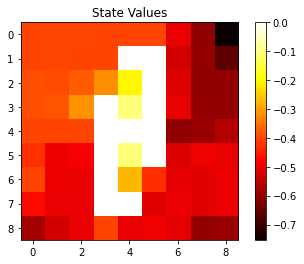

Episode :  20


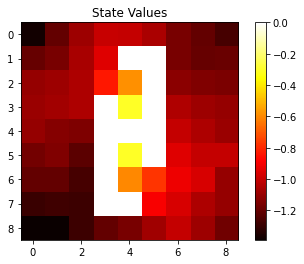

Episode :  30


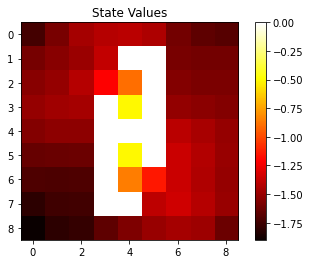

Episode :  40


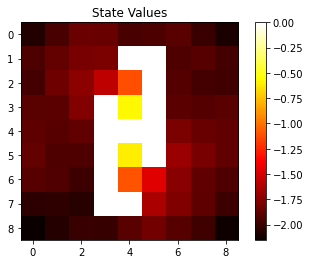

Episode :  50


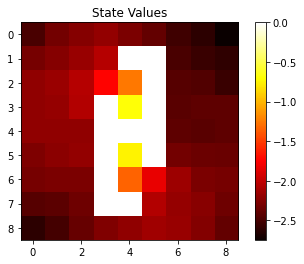

Episode :  60


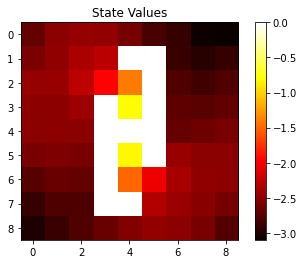

Episode :  70


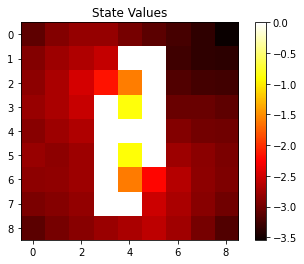

Episode :  80


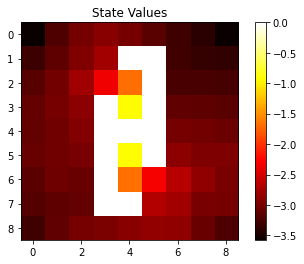

Episode :  90


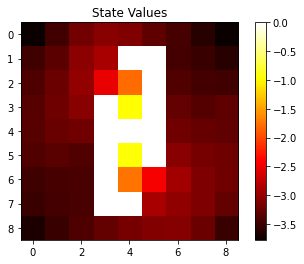

Episode :  100


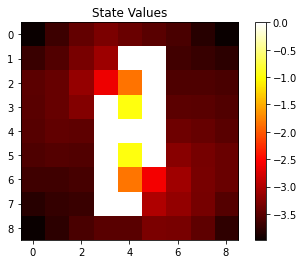

Episode:  500


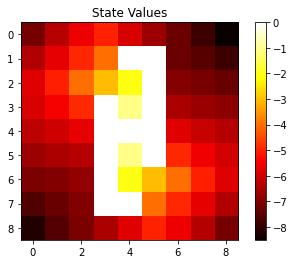

In [10]:
Q = MazeGrid(9)
Q.Q_learning(gamma = 1, epsilon = .15, alpha = 0.1, episodes = 500)

Episode: 10


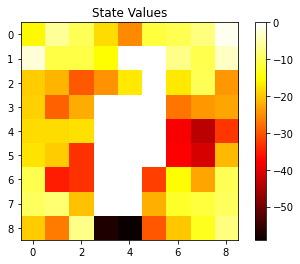

Episode: 20


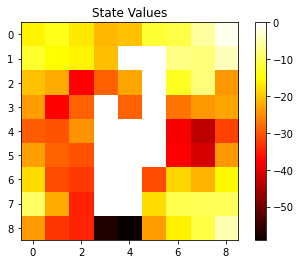

Episode: 30


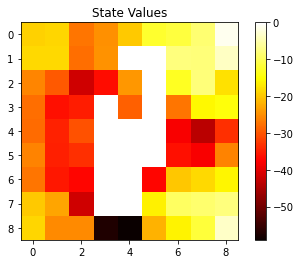

Episode: 40


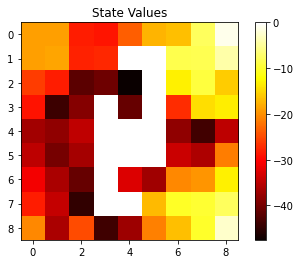

Episode: 50


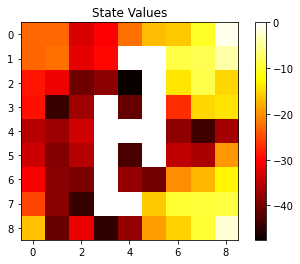

Episode: 60


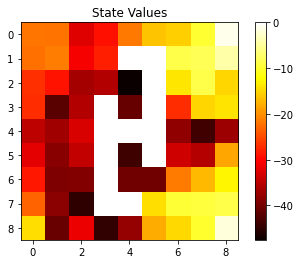

Episode: 70


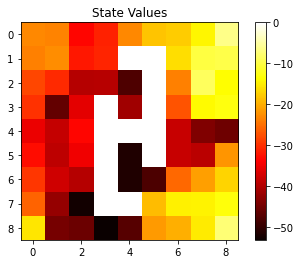

Episode: 80


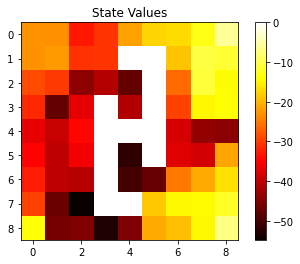

Episode: 90


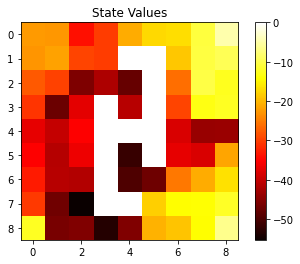

Episode: 100


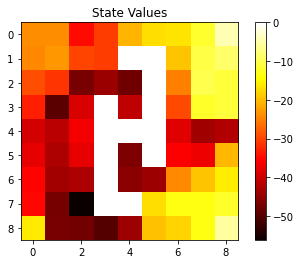

Episode: 110


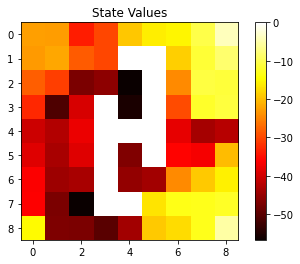

Episode: 120


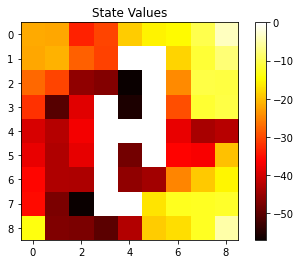

Episode: 130


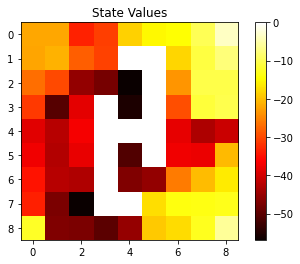

Episode: 140


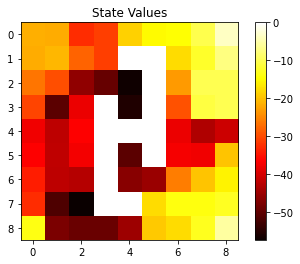

Episode: 150


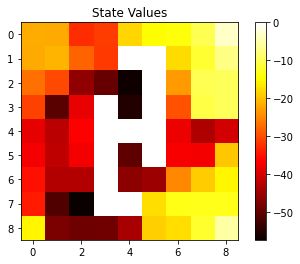

Episode: 160


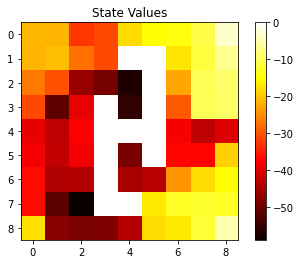

Episode: 170


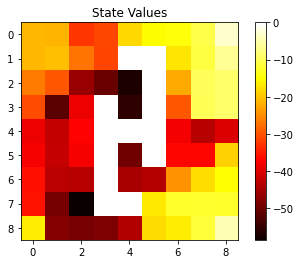

Episode: 180


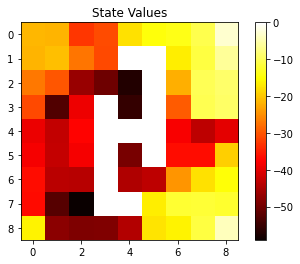

Episode: 190


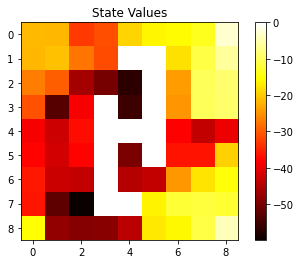

Episode: 200


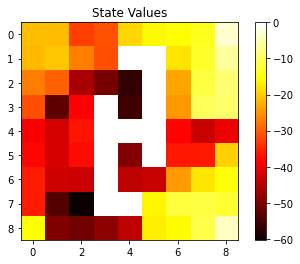

Episode: 210


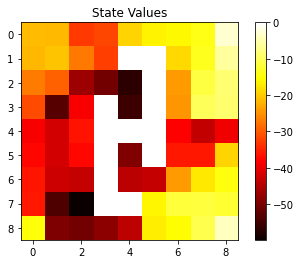

Episode: 220


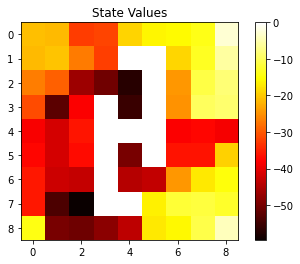

Episode: 230


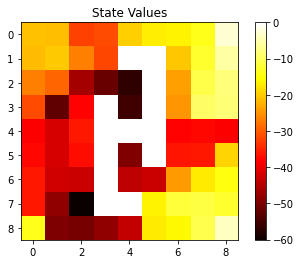

Episode: 240


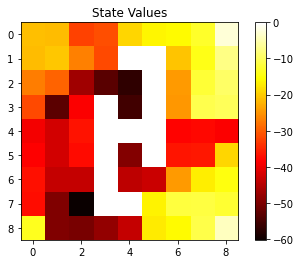

Episode: 250


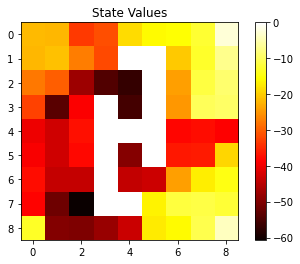

Episode: 260


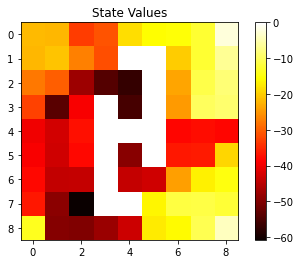

Episode: 270


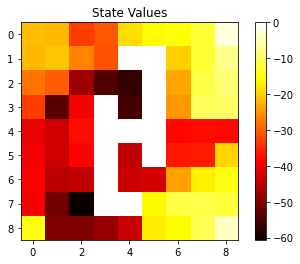

Episode: 280


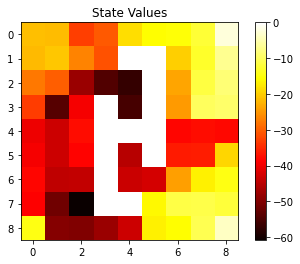

Episode: 290


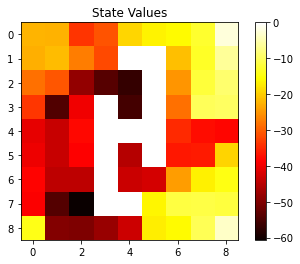

Episode: 300


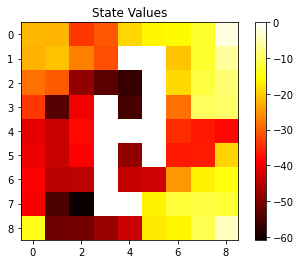

Episode: 310


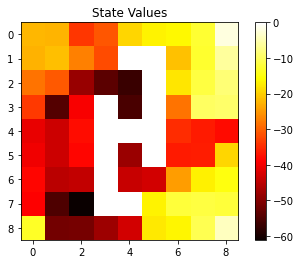

Episode: 320


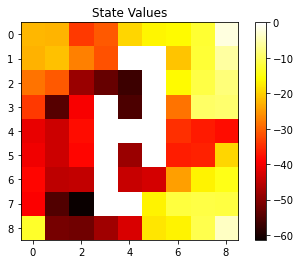

Episode: 330


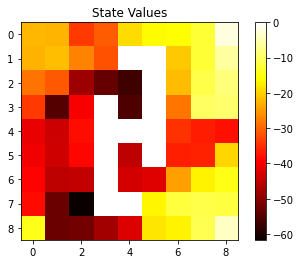

Episode: 340


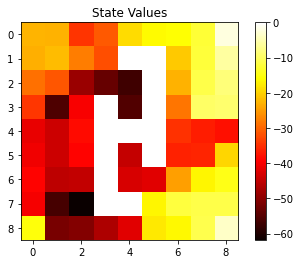

Episode: 350


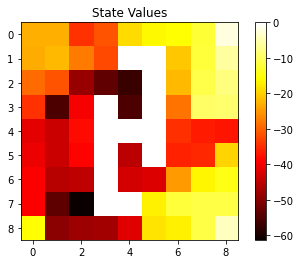

Episode: 360


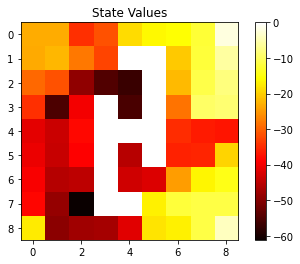

Episode: 370


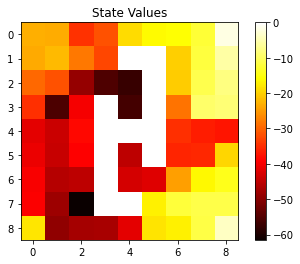

Episode: 380


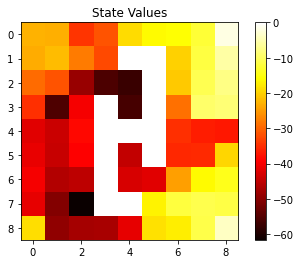

Episode: 390


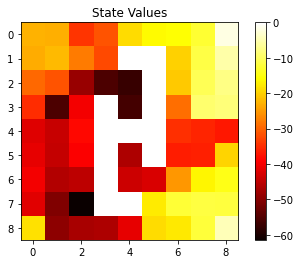

Episode: 400


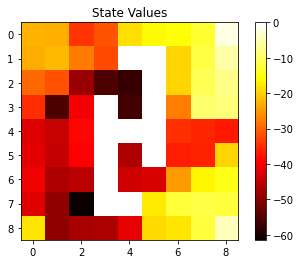

Episode: 410


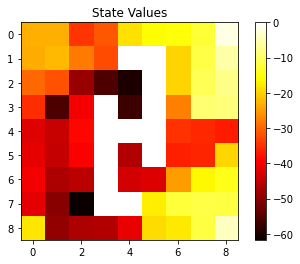

Episode: 420


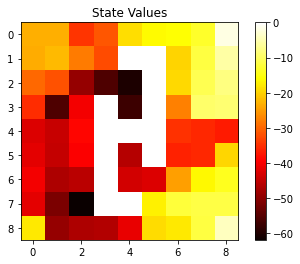

Episode: 430


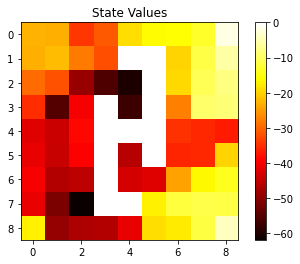

Episode: 440


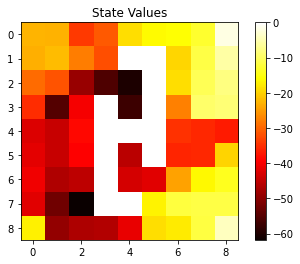

Episode: 450


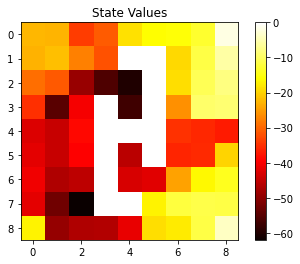

Episode: 460


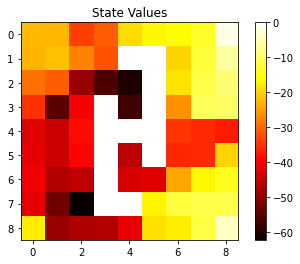

Episode: 470


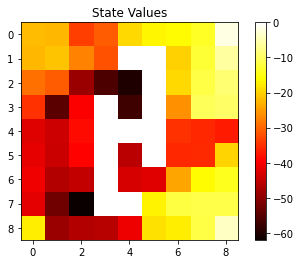

Episode: 480


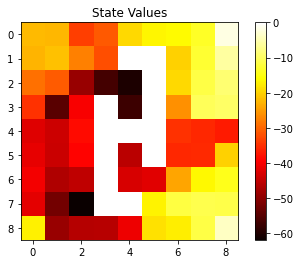

Episode: 490


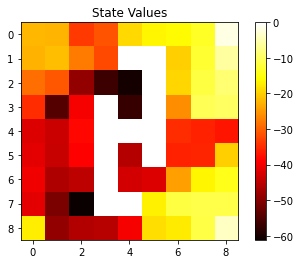

Episode: 500


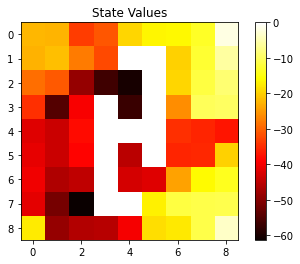

In [11]:
MC = MazeGrid(9)
MC.on_policy_first_visit_MC(episodes = 500)

In [ ]:
# Some code checking
test = MazeGrid(9)
test.current_state

In [ ]:
# set state so that the barrier is to the right , and bomb is just above

# testing my step function with change_values = False and also testing 
# how I can through my state_values using s_prime from step
test.current_state = (2, 3)
test.state_action_values[3, 3] = 10
print('terminal: ', test.terminal)
up = test.step(test.current_state, action = Actions[1], change_values = False)[0]
print(test.state_action_values[up], test.terminal)

#test step into bomb
print('Current State:' , test.current_state)
print(' taking step South ...')
next_state, reward = test.step(test.current_state, Actions[1])

#also report current_state along with next_state to see if it's being updated correctly
print('New State && Reward:' , test.current_state, next_state, reward) 
print('\n')

# go back to state (8, 3) and check step into barrier
test.current_state = (8, 3)
print('Current State:' , test.current_state)
print(' taking step North ...')
next_state, reward = test.step(test.current_state, Actions[0])
print('New State && Reward:' , test.current_state, next_state, reward)

print('\n')
# from state (3, 4), check what happens if step South and win
test.current_state = (3, 4)
print('Current State:' , test.current_state)
print(' taking step South...')
next_state, reward = test.step(test.current_state, Actions[1])
print('New State && Reward:' , test.current_state, next_state, reward)

